In [40]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [41]:
from rdmg import rdm_ginibre
from tools import gen_paulis
from qiskit_textbook.widgets import plot_bloch_vector_spherical

rrho = rdm_ginibre(2)
print(np.trace(np.dot(rrho,rrho)))
Paulis = gen_paulis()
print(np.trace(np.dot(rrho,Paulis[0])))

target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
Variable(torch.tensor(target_vector ))
print(target_vector)
#plot_bloch_vector_spherical(target_vector)


(0.9649629910991029+0j)
(-0.9311721027362145+0j)
[-0.9311721027362145, 0.23315949402227248, 0.0920931464947341]


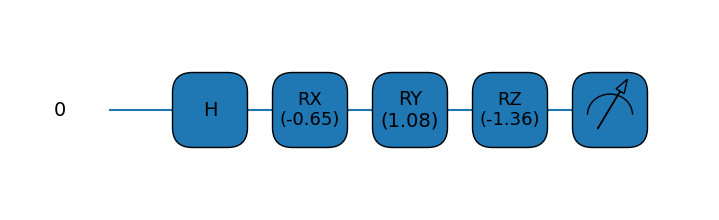

In [42]:
device = qml.device('qiskit.aer', wires=3, backend='qasm_simulator')
params = np.random.normal(0,np.pi/2, 3)
params = Variable(torch.tensor(params), requires_grad=True)


@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=0))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [43]:
def cost(params):
    L = 0
    for k in range(3):
        L += torch.abs(circuit(params, Paulis[k]) - target_vector[k])
    return L

In [44]:
opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params

In [45]:
for epoch in range(50):
    opt.zero_grad()
    loss = cost(params)
    print(epoch, loss)
    loss.backward()
    opt.step()

    if loss < best_loss:
        best_loss = 1*loss
        best_params = 1*params

0 tensor(2.6373, dtype=torch.float64, grad_fn=<AddBackward0>)
1 tensor(2.6080, dtype=torch.float64, grad_fn=<AddBackward0>)
2 tensor(2.5279, dtype=torch.float64, grad_fn=<AddBackward0>)
3 tensor(2.4029, dtype=torch.float64, grad_fn=<AddBackward0>)
4 tensor(2.3463, dtype=torch.float64, grad_fn=<AddBackward0>)
5 tensor(2.2584, dtype=torch.float64, grad_fn=<AddBackward0>)
6 tensor(2.1744, dtype=torch.float64, grad_fn=<AddBackward0>)
7 tensor(2.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
8 tensor(2.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
9 tensor(2.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
10 tensor(2.2276, dtype=torch.float64, grad_fn=<AddBackward0>)
11 tensor(2.2686, dtype=torch.float64, grad_fn=<AddBackward0>)
12 tensor(2.2217, dtype=torch.float64, grad_fn=<AddBackward0>)
13 tensor(2.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
14 tensor(2.1417, dtype=torch.float64, grad_fn=<AddBackward0>)
15 tensor(2.2159, dtype=torch.float64, grad_fn=<AddBackward0>)
16

In [47]:
X_exp = circuit(best_params, Paulis[0]).item()
Y_exp = circuit(best_params, Paulis[1]).item()
Z_exp = circuit(best_params, Paulis[2]).item()
rho_p = 0.5*(torch.eye(2) + X_exp*Paulis[0] + Y_exp*Paulis[1] + Z_exp*Paulis[2]).detach().numpy()
print(X_exp, Y_exp, Z_exp)
print(target_vector)

-0.9375 0.23046875 0.203125
[-0.9311721027362145, 0.23315949402227248, 0.0920931464947341]


In [48]:
print(rrho)
print(rho_p)

[[ 0.54604657+0.j         -0.46558605-0.11657975j]
 [-0.46558605+0.11657975j  0.45395343+0.j        ]]
[[ 0.6015625+0.j         -0.46875  -0.11523438j]
 [-0.46875  +0.11523438j  0.3984375+0.j        ]]


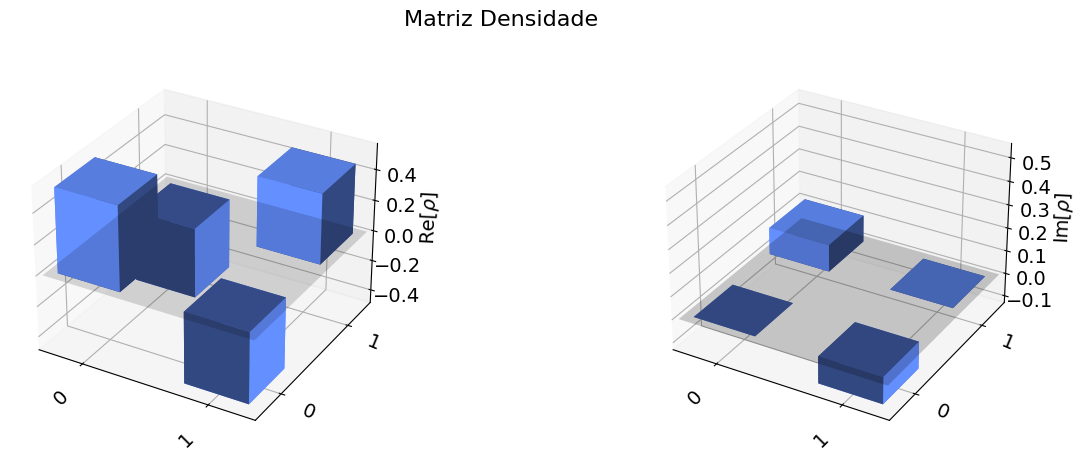

In [49]:
from qiskit.visualization import plot_state_city
plot_state_city(rrho, title='Matriz Densidade')

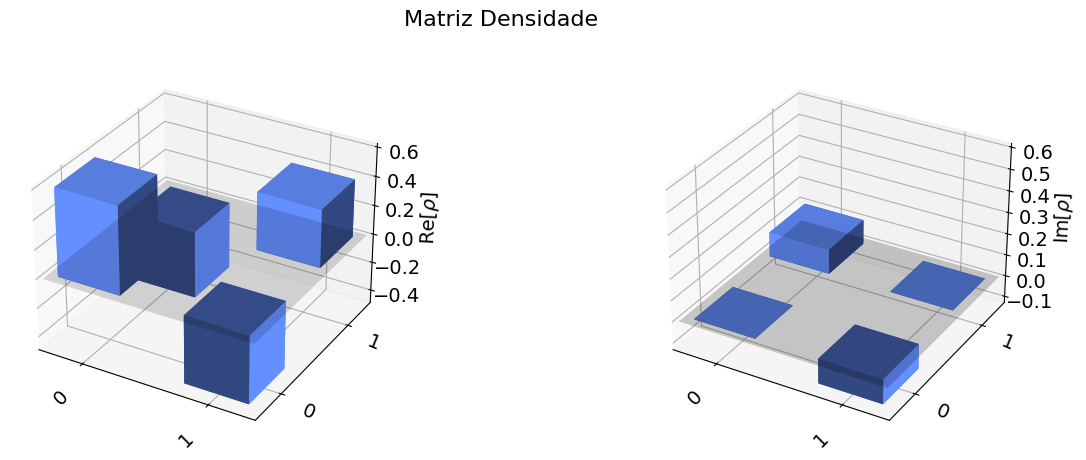

In [50]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_p, title='Matriz Densidade')

In [53]:
def fidelity_mm(d, rho, zeta):
    from mat_func import mat_sqrt
    from pTrace import trace
    A = np.zeros((d, d), dtype=complex)
    B = np.zeros((d, d), dtype=complex)
    A = mat_sqrt(d, rho)
    B = np.matmul(np.matmul(A, zeta), A)
    A = mat_sqrt(d, B)
    return trace(d, A)

In [55]:
print(fidelity_mm(2,rrho,rho_p))

(0.9971674177354763+0j)


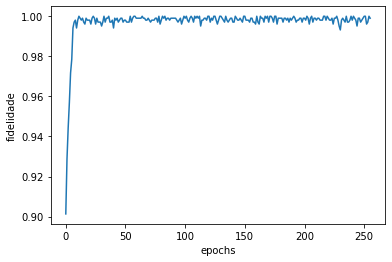

In [66]:
plt.plot(epochs, fidelity)
plt.xlabel('epochs')
plt.ylabel('fidelidade')
plt.show()

Para estados puros, a fidelidade é igual ao quadrado do valor esperado.

valor esperado pode ser calculado diretamente do VQA.

In [107]:
def fidelidade(target_op):
    return circuit(best_params, M=target_op).item()
def init_state_params():
    params = np.random.normal(0,np.pi/2, 3)
    params = Variable(torch.tensor(params), requires_grad=True)
    a = random.random()
    b = (1-a**2)**0.5
    target_state = np.array([a, b])
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op, params

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))

def cost(params,target_op):
    L = (1-(circuit(params, M=target_op)))**2
    return L

def train(params,target_op):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params,target_op)
    best_params = 1*params
    for epoch in range(32):
        opt.zero_grad()
        loss = cost(params,target_op)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params, best_loss


In [109]:
fidelidade_media=0
for i in range(100):
    target_op, params = init_state_params()
    best_params, best_loss = train(params,target_op)
    fidelidade_media += fidelidade(target_op)**2
fidelidade_media = fidelidade_media/100
print(fidelidade_media)

0 0.001377105712890625
1 0.00042057037353515625
2 3.4332275390625e-05
3 2.384185791015625e-05
4 3.814697265625e-06
5 4.673004150390625e-05
6 6.103515625e-05
7 6.103515625e-05
8 0.0001373291015625
9 0.00011539459228515625
10 0.00021457672119140625
11 9.5367431640625e-05
12 1.52587890625e-05
13 6.103515625e-05
14 1.52587890625e-05
15 8.58306884765625e-06
16 0.0
17 9.5367431640625e-07
18 8.58306884765625e-06
19 0.0
20 3.814697265625e-06
21 0.0
22 0.0
23 8.58306884765625e-06
24 3.814697265625e-06
0 0.005802154541015625
1 0.0033197402954101562
2 0.001102447509765625
3 0.0009164810180664062
4 0.000186920166015625
5 7.724761962890625e-05
6 2.384185791015625e-05
7 1.52587890625e-05
8 9.5367431640625e-07
9 0.0
10 1.52587890625e-05
11 2.384185791015625e-05
12 7.724761962890625e-05
13 0.000186920166015625
14 7.724761962890625e-05
15 0.000244140625
16 0.000244140625
17 0.00011539459228515625
18 0.000308990478515625
19 0.00021457672119140625
20 0.0003814697265625
21 0.00011539459228515625
22 0.0001

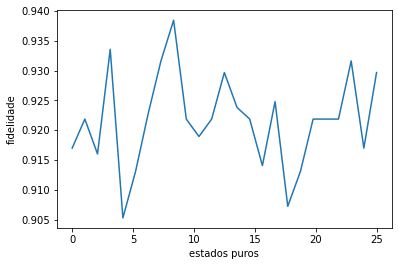

In [112]:
x=np.linspace(0,len(fidelity),len(fidelity))
plt.plot(x, fidelity)
plt.xlabel('estados puros')
plt.ylabel('fidelidade')
plt.show()